Transformers. First version, and results for presentation



In [ ]:
import pandas as pd
from transformers import DistilBertTokenizerFast
import torch
from torch.utils.data import Dataset

data_path = './data/diabetes-dataset/diabetes_012_health_indicators_BRFSS2015.csv'
df = pd.read_csv(data_path)

print("Column Names:", df.columns)

# Set the features and target
X = df.drop(columns=['Diabetes_012'])
y = df[['Diabetes_012']]


print("Target Values Distribution:", y['Diabetes_012'].value_counts())


c:\Users\rockr\anaconda3\envs\yologpu1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Column Names: Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')
Target Values Distribution: Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64


In [2]:
print(X.columns)
print(y.columns)


Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')
Index(['Diabetes_012'], dtype='object')


preprocess data

In [3]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

class DiabetesDataset(Dataset):
    def __init__(self, features_df, target_df, tokenizer, target_col):
        self.features_df = features_df
        self.labels = torch.tensor(target_df[target_col].values)
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.features_df)

    def __getitem__(self, idx):
        features = self.features_df.iloc[idx]
        text = " ".join([str(val) for val in features])
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=128)
        input_ids = encoding['input_ids']
        attention_mask = encoding['attention_mask']
        label = self.labels[idx].item()
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize the dataset
target_col = 'Diabetes_012'
diabetes_dataset = DiabetesDataset(X, y, tokenizer, target_col)

# Fetch a sample to verify
print(diabetes_dataset[0])


{'input_ids': tensor([ 101, 1015, 1012, 1014, 1015, 1012, 1014, 1015, 1012, 1014, 2871, 1012,
        1014, 1015, 1012, 1014, 1014, 1012, 1014, 1014, 1012, 1014, 1014, 1012,
        1014, 1014, 1012, 1014, 1015, 1012, 1014, 1014, 1012, 1014, 1015, 1012,
        1014, 1014, 1012, 1014, 1019, 1012, 1014, 2324, 1012, 1014, 2321, 1012,
        1014, 1015, 1012, 1014, 1014, 1012, 1014, 1023, 1012, 1014, 1018, 1012,
        1014, 1017, 1012, 1014,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1

train model

In [4]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Initialize the model and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3).to(device)

# Set up training arguments with checkpoint saving
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",  # Save checkpoint after each epoch
    save_total_limit=2  # Only keep the last 2 checkpoints
)

# Split the dataset
train_size = int(0.9 * len(X))
test_size = len(X) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(diabetes_dataset, [train_size, test_size])

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\rockr\anaconda3\envs\yologpu1\Lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


checking all good before training

In [5]:
# Verify Data Loaders
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Using device: {device}")



Number of training samples: 228312
Number of test samples: 25368
Using device: cuda


In [ ]:
trainer.train()


  0%|          | 0/42810 [00:00<?, ?it/s]c:\Users\rockr\anaconda3\envs\yologpu1\Lib\site-packages\transformers\models\distilbert\modeling_distilbert.py:403: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
  1%|          | 501/42810 [01:32<2:12:55,  5.31it/s]

{'loss': 0.4454, 'grad_norm': 2.6310677528381348, 'learning_rate': 1.976640971735576e-05, 'epoch': 0.04}


  2%|▏         | 1001/42810 [03:06<2:12:49,  5.25it/s]

{'loss': 0.437, 'grad_norm': 1.694321632385254, 'learning_rate': 1.9532819434711517e-05, 'epoch': 0.07}


  4%|▎         | 1501/42810 [04:41<2:11:41,  5.23it/s]

{'loss': 0.4217, 'grad_norm': 1.1643290519714355, 'learning_rate': 1.9299229152067275e-05, 'epoch': 0.11}


  5%|▍         | 2001/42810 [06:16<2:12:47,  5.12it/s]

{'loss': 0.4295, 'grad_norm': 2.5311567783355713, 'learning_rate': 1.9065638869423033e-05, 'epoch': 0.14}


  6%|▌         | 2501/42810 [07:52<2:10:10,  5.16it/s]

{'loss': 0.4128, 'grad_norm': 1.6446328163146973, 'learning_rate': 1.883204858677879e-05, 'epoch': 0.18}


  7%|▋         | 3001/42810 [09:28<2:08:01,  5.18it/s]

{'loss': 0.4105, 'grad_norm': 2.8956339359283447, 'learning_rate': 1.859845830413455e-05, 'epoch': 0.21}


  8%|▊         | 3501/42810 [11:04<2:06:27,  5.18it/s]

{'loss': 0.4156, 'grad_norm': 2.0552291870117188, 'learning_rate': 1.8364868021490307e-05, 'epoch': 0.25}


  9%|▉         | 4001/42810 [12:40<2:04:47,  5.18it/s]

{'loss': 0.418, 'grad_norm': 1.0164839029312134, 'learning_rate': 1.8131277738846065e-05, 'epoch': 0.28}


 11%|█         | 4501/42810 [14:17<2:03:47,  5.16it/s]

{'loss': 0.4123, 'grad_norm': 1.3424997329711914, 'learning_rate': 1.7897687456201826e-05, 'epoch': 0.32}


 12%|█▏        | 5001/42810 [15:53<2:03:01,  5.12it/s]

{'loss': 0.4016, 'grad_norm': 2.153399705886841, 'learning_rate': 1.766409717355758e-05, 'epoch': 0.35}


 13%|█▎        | 5501/42810 [17:29<2:00:43,  5.15it/s]

{'loss': 0.3955, 'grad_norm': 2.4335527420043945, 'learning_rate': 1.7430506890913338e-05, 'epoch': 0.39}


 14%|█▍        | 6001/42810 [19:05<1:59:20,  5.14it/s]

{'loss': 0.4095, 'grad_norm': 1.6153334379196167, 'learning_rate': 1.7196916608269096e-05, 'epoch': 0.42}


 15%|█▌        | 6501/42810 [20:42<1:57:03,  5.17it/s]

{'loss': 0.4025, 'grad_norm': 1.595699667930603, 'learning_rate': 1.6963326325624857e-05, 'epoch': 0.46}


 16%|█▋        | 7001/42810 [22:18<1:55:47,  5.15it/s]

{'loss': 0.3966, 'grad_norm': 2.149059772491455, 'learning_rate': 1.6729736042980612e-05, 'epoch': 0.49}


 18%|█▊        | 7501/42810 [23:54<1:53:57,  5.16it/s]

{'loss': 0.3986, 'grad_norm': 2.6274826526641846, 'learning_rate': 1.649614576033637e-05, 'epoch': 0.53}


 19%|█▊        | 8001/42810 [25:31<1:51:58,  5.18it/s]

{'loss': 0.3958, 'grad_norm': 2.129368782043457, 'learning_rate': 1.626255547769213e-05, 'epoch': 0.56}


 20%|█▉        | 8501/42810 [27:07<1:50:15,  5.19it/s]

{'loss': 0.4061, 'grad_norm': 3.740892171859741, 'learning_rate': 1.602896519504789e-05, 'epoch': 0.6}


 21%|██        | 9001/42810 [28:42<1:48:51,  5.18it/s]

{'loss': 0.4019, 'grad_norm': 0.9866651296615601, 'learning_rate': 1.5795374912403643e-05, 'epoch': 0.63}


 22%|██▏       | 9501/42810 [30:18<1:46:44,  5.20it/s]

{'loss': 0.3972, 'grad_norm': 1.2044843435287476, 'learning_rate': 1.55617846297594e-05, 'epoch': 0.67}


 23%|██▎       | 10001/42810 [31:53<1:45:10,  5.20it/s]

{'loss': 0.414, 'grad_norm': 1.470272421836853, 'learning_rate': 1.5328194347115163e-05, 'epoch': 0.7}


 25%|██▍       | 10501/42810 [33:29<1:43:25,  5.21it/s]

{'loss': 0.4025, 'grad_norm': 1.2921760082244873, 'learning_rate': 1.5094604064470919e-05, 'epoch': 0.74}


 26%|██▌       | 11001/42810 [35:04<1:41:45,  5.21it/s]

{'loss': 0.4071, 'grad_norm': 4.21263313293457, 'learning_rate': 1.4861013781826677e-05, 'epoch': 0.77}


 27%|██▋       | 11501/42810 [36:39<1:40:21,  5.20it/s]

{'loss': 0.3879, 'grad_norm': 2.335622787475586, 'learning_rate': 1.4627423499182436e-05, 'epoch': 0.81}


 28%|██▊       | 12001/42810 [38:15<1:38:38,  5.21it/s]

{'loss': 0.4081, 'grad_norm': 1.3291785717010498, 'learning_rate': 1.4393833216538194e-05, 'epoch': 0.84}


 29%|██▉       | 12501/42810 [39:50<1:36:57,  5.21it/s]

{'loss': 0.4067, 'grad_norm': 1.7290979623794556, 'learning_rate': 1.416024293389395e-05, 'epoch': 0.88}


 30%|███       | 13001/42810 [41:25<1:35:40,  5.19it/s]

{'loss': 0.4062, 'grad_norm': 1.0722492933273315, 'learning_rate': 1.392665265124971e-05, 'epoch': 0.91}


 32%|███▏      | 13501/42810 [43:01<1:33:47,  5.21it/s]

{'loss': 0.4112, 'grad_norm': 1.2710208892822266, 'learning_rate': 1.3693062368605468e-05, 'epoch': 0.95}


 33%|███▎      | 14001/42810 [44:36<1:32:04,  5.22it/s]

{'loss': 0.4134, 'grad_norm': 1.4627366065979004, 'learning_rate': 1.3459472085961226e-05, 'epoch': 0.98}


                                                       
 33%|███▎      | 14270/42810 [47:00<1:20:29,  5.91it/s]

{'eval_loss': 0.4240972399711609, 'eval_runtime': 93.4244, 'eval_samples_per_second': 271.535, 'eval_steps_per_second': 16.976, 'epoch': 1.0}


 34%|███▍      | 14501/42810 [47:45<1:31:07,  5.18it/s]  

{'loss': 0.4011, 'grad_norm': 1.518689513206482, 'learning_rate': 1.3225881803316982e-05, 'epoch': 1.02}


 35%|███▌      | 15001/42810 [49:21<1:29:03,  5.20it/s]

{'loss': 0.4176, 'grad_norm': 2.7791242599487305, 'learning_rate': 1.2992291520672741e-05, 'epoch': 1.05}


 36%|███▌      | 15501/42810 [50:56<1:27:29,  5.20it/s]

{'loss': 0.4035, 'grad_norm': 1.2722725868225098, 'learning_rate': 1.27587012380285e-05, 'epoch': 1.09}


 37%|███▋      | 16001/42810 [52:32<1:26:06,  5.19it/s]

{'loss': 0.3888, 'grad_norm': 2.29439640045166, 'learning_rate': 1.2525110955384257e-05, 'epoch': 1.12}


 39%|███▊      | 16501/42810 [54:08<1:23:56,  5.22it/s]

{'loss': 0.392, 'grad_norm': 2.073272228240967, 'learning_rate': 1.2291520672740017e-05, 'epoch': 1.16}


 40%|███▉      | 17001/42810 [55:43<1:22:53,  5.19it/s]

{'loss': 0.4046, 'grad_norm': 1.9307500123977661, 'learning_rate': 1.2057930390095773e-05, 'epoch': 1.19}


 41%|████      | 17501/42810 [57:19<1:21:05,  5.20it/s]

{'loss': 0.4087, 'grad_norm': 1.0317256450653076, 'learning_rate': 1.182434010745153e-05, 'epoch': 1.23}


 42%|████▏     | 18001/42810 [58:54<1:19:45,  5.18it/s]

{'loss': 0.3879, 'grad_norm': 1.9928838014602661, 'learning_rate': 1.1590749824807289e-05, 'epoch': 1.26}


 43%|████▎     | 18501/42810 [1:00:30<1:17:58,  5.20it/s]

{'loss': 0.413, 'grad_norm': 2.0544803142547607, 'learning_rate': 1.1357159542163048e-05, 'epoch': 1.3}


 44%|████▍     | 19001/42810 [1:02:05<1:16:21,  5.20it/s]

{'loss': 0.3959, 'grad_norm': 1.2918128967285156, 'learning_rate': 1.1123569259518804e-05, 'epoch': 1.33}


 46%|████▌     | 19501/42810 [1:03:40<1:14:36,  5.21it/s]

{'loss': 0.3911, 'grad_norm': 1.6417604684829712, 'learning_rate': 1.0889978976874562e-05, 'epoch': 1.37}


 47%|████▋     | 20001/42810 [1:05:15<1:13:09,  5.20it/s]

{'loss': 0.4021, 'grad_norm': 1.2086788415908813, 'learning_rate': 1.0656388694230322e-05, 'epoch': 1.4}


 48%|████▊     | 20501/42810 [1:06:51<1:11:35,  5.19it/s]

{'loss': 0.3976, 'grad_norm': 0.9316544532775879, 'learning_rate': 1.042279841158608e-05, 'epoch': 1.44}


 49%|████▉     | 21001/42810 [1:08:26<1:10:06,  5.18it/s]

{'loss': 0.4036, 'grad_norm': 1.0202677249908447, 'learning_rate': 1.0189208128941836e-05, 'epoch': 1.47}


 50%|█████     | 21501/42810 [1:10:01<1:08:14,  5.20it/s]

{'loss': 0.4081, 'grad_norm': 1.2370036840438843, 'learning_rate': 9.955617846297595e-06, 'epoch': 1.51}


 51%|█████▏    | 22001/42810 [1:11:36<1:06:32,  5.21it/s]

{'loss': 0.3872, 'grad_norm': 1.38107168674469, 'learning_rate': 9.722027563653352e-06, 'epoch': 1.54}


 53%|█████▎    | 22501/42810 [1:13:12<1:05:05,  5.20it/s]

{'loss': 0.4053, 'grad_norm': 1.4009958505630493, 'learning_rate': 9.488437281009111e-06, 'epoch': 1.58}


 54%|█████▎    | 23001/42810 [1:14:47<1:03:22,  5.21it/s]

{'loss': 0.3938, 'grad_norm': 2.2878024578094482, 'learning_rate': 9.254846998364869e-06, 'epoch': 1.61}


 55%|█████▍    | 23501/42810 [1:16:22<1:01:47,  5.21it/s]

{'loss': 0.389, 'grad_norm': 0.9400269985198975, 'learning_rate': 9.021256715720627e-06, 'epoch': 1.65}


 56%|█████▌    | 24001/42810 [1:17:57<1:00:00,  5.22it/s]

{'loss': 0.3968, 'grad_norm': 0.7342543601989746, 'learning_rate': 8.787666433076385e-06, 'epoch': 1.68}


 57%|█████▋    | 24501/42810 [1:19:32<58:13,  5.24it/s]  

{'loss': 0.399, 'grad_norm': 2.284647226333618, 'learning_rate': 8.554076150432143e-06, 'epoch': 1.72}


 58%|█████▊    | 25001/42810 [1:21:07<56:42,  5.23it/s]

{'loss': 0.3928, 'grad_norm': 1.0725270509719849, 'learning_rate': 8.3204858677879e-06, 'epoch': 1.75}


 60%|█████▉    | 25501/42810 [1:22:42<54:59,  5.25it/s]

{'loss': 0.3979, 'grad_norm': 2.133112907409668, 'learning_rate': 8.086895585143658e-06, 'epoch': 1.79}


 61%|██████    | 26001/42810 [1:24:16<53:24,  5.24it/s]

{'loss': 0.3882, 'grad_norm': 0.8658791184425354, 'learning_rate': 7.853305302499416e-06, 'epoch': 1.82}


 62%|██████▏   | 26501/42810 [1:25:51<51:36,  5.27it/s]

{'loss': 0.4022, 'grad_norm': 1.4797167778015137, 'learning_rate': 7.619715019855175e-06, 'epoch': 1.86}


 63%|██████▎   | 27001/42810 [1:27:25<50:06,  5.26it/s]

{'loss': 0.4031, 'grad_norm': 0.8495696187019348, 'learning_rate': 7.386124737210932e-06, 'epoch': 1.89}


 64%|██████▍   | 27501/42810 [1:28:59<48:41,  5.24it/s]

{'loss': 0.4021, 'grad_norm': 0.9166727066040039, 'learning_rate': 7.152534454566691e-06, 'epoch': 1.93}


 65%|██████▌   | 28001/42810 [1:30:34<46:54,  5.26it/s]

{'loss': 0.3982, 'grad_norm': 1.1980892419815063, 'learning_rate': 6.918944171922448e-06, 'epoch': 1.96}


 67%|██████▋   | 28501/42810 [1:32:08<45:04,  5.29it/s]

{'loss': 0.3887, 'grad_norm': 1.7285958528518677, 'learning_rate': 6.685353889278207e-06, 'epoch': 2.0}


                                                       
 67%|██████▋   | 28540/42810 [1:33:48<39:32,  6.01it/s]

{'eval_loss': 0.39936745166778564, 'eval_runtime': 92.4495, 'eval_samples_per_second': 274.398, 'eval_steps_per_second': 17.155, 'epoch': 2.0}


 68%|██████▊   | 29001/42810 [1:35:16<43:40,  5.27it/s]    

{'loss': 0.407, 'grad_norm': 1.3659056425094604, 'learning_rate': 6.451763606633965e-06, 'epoch': 2.03}


 69%|██████▉   | 29501/42810 [1:36:50<42:09,  5.26it/s]

{'loss': 0.3905, 'grad_norm': 1.352389931678772, 'learning_rate': 6.218173323989722e-06, 'epoch': 2.07}


 70%|███████   | 30001/42810 [1:38:25<40:34,  5.26it/s]

{'loss': 0.384, 'grad_norm': 2.4029715061187744, 'learning_rate': 5.984583041345481e-06, 'epoch': 2.1}


 71%|███████   | 30501/42810 [1:39:59<39:01,  5.26it/s]

{'loss': 0.4014, 'grad_norm': 1.4454704523086548, 'learning_rate': 5.750992758701238e-06, 'epoch': 2.14}


 72%|███████▏  | 31001/42810 [1:41:34<37:34,  5.24it/s]

{'loss': 0.3969, 'grad_norm': 1.885632872581482, 'learning_rate': 5.517402476056997e-06, 'epoch': 2.17}


 74%|███████▎  | 31501/42810 [1:43:08<35:57,  5.24it/s]

{'loss': 0.4024, 'grad_norm': 1.1113547086715698, 'learning_rate': 5.283812193412754e-06, 'epoch': 2.21}


 75%|███████▍  | 32001/42810 [1:44:43<34:27,  5.23it/s]

{'loss': 0.3899, 'grad_norm': 0.7623665928840637, 'learning_rate': 5.050221910768513e-06, 'epoch': 2.24}


 76%|███████▌  | 32501/42810 [1:46:18<32:48,  5.24it/s]

{'loss': 0.3745, 'grad_norm': 2.6553566455841064, 'learning_rate': 4.8166316281242705e-06, 'epoch': 2.28}


 77%|███████▋  | 33001/42810 [1:47:52<31:06,  5.25it/s]

{'loss': 0.4085, 'grad_norm': 1.7342640161514282, 'learning_rate': 4.583041345480028e-06, 'epoch': 2.31}


 78%|███████▊  | 33501/42810 [1:49:27<29:35,  5.24it/s]

{'loss': 0.4045, 'grad_norm': 1.2331938743591309, 'learning_rate': 4.349451062835787e-06, 'epoch': 2.35}


 79%|███████▉  | 34001/42810 [1:51:02<28:00,  5.24it/s]

{'loss': 0.3991, 'grad_norm': 1.9308760166168213, 'learning_rate': 4.115860780191545e-06, 'epoch': 2.38}


 81%|████████  | 34501/42810 [1:52:36<26:20,  5.26it/s]

{'loss': 0.396, 'grad_norm': 1.1452116966247559, 'learning_rate': 3.882270497547303e-06, 'epoch': 2.42}


 82%|████████▏ | 35001/42810 [1:54:11<24:55,  5.22it/s]

{'loss': 0.4032, 'grad_norm': 3.561846971511841, 'learning_rate': 3.6486802149030603e-06, 'epoch': 2.45}


 83%|████████▎ | 35501/42810 [1:55:45<23:15,  5.24it/s]

{'loss': 0.398, 'grad_norm': 1.73945152759552, 'learning_rate': 3.415089932258818e-06, 'epoch': 2.49}


 84%|████████▍ | 36001/42810 [1:57:20<21:35,  5.25it/s]

{'loss': 0.4053, 'grad_norm': 0.9798424243927002, 'learning_rate': 3.181499649614576e-06, 'epoch': 2.52}


 85%|████████▌ | 36501/42810 [1:58:54<20:05,  5.24it/s]

{'loss': 0.3923, 'grad_norm': 1.5541410446166992, 'learning_rate': 2.947909366970334e-06, 'epoch': 2.56}


 86%|████████▋ | 37001/42810 [2:00:29<18:31,  5.23it/s]

{'loss': 0.391, 'grad_norm': 1.8974030017852783, 'learning_rate': 2.7143190843260926e-06, 'epoch': 2.59}


 88%|████████▊ | 37501/42810 [2:02:04<16:54,  5.24it/s]

{'loss': 0.3887, 'grad_norm': 1.1931971311569214, 'learning_rate': 2.4807288016818505e-06, 'epoch': 2.63}


 89%|████████▉ | 38001/42810 [2:03:38<15:16,  5.25it/s]

{'loss': 0.3936, 'grad_norm': 2.0369482040405273, 'learning_rate': 2.2471385190376084e-06, 'epoch': 2.66}


 90%|████████▉ | 38501/42810 [2:05:13<13:41,  5.24it/s]

{'loss': 0.3993, 'grad_norm': 0.8551033139228821, 'learning_rate': 2.0135482363933663e-06, 'epoch': 2.7}


 91%|█████████ | 39001/42810 [2:06:48<12:08,  5.23it/s]

{'loss': 0.3857, 'grad_norm': 2.6460554599761963, 'learning_rate': 1.7799579537491241e-06, 'epoch': 2.73}


 92%|█████████▏| 39501/42810 [2:08:23<10:33,  5.22it/s]

{'loss': 0.4034, 'grad_norm': 0.8387027382850647, 'learning_rate': 1.5463676711048822e-06, 'epoch': 2.77}


 93%|█████████▎| 40001/42810 [2:09:58<08:58,  5.22it/s]

{'loss': 0.3917, 'grad_norm': 0.7686766982078552, 'learning_rate': 1.3127773884606401e-06, 'epoch': 2.8}


 95%|█████████▍| 40501/42810 [2:11:33<07:20,  5.24it/s]

{'loss': 0.3808, 'grad_norm': 1.087939977645874, 'learning_rate': 1.0791871058163982e-06, 'epoch': 2.84}


 96%|█████████▌| 41001/42810 [2:13:08<05:47,  5.20it/s]

{'loss': 0.4, 'grad_norm': 3.260347843170166, 'learning_rate': 8.455968231721561e-07, 'epoch': 2.87}


 97%|█████████▋| 41501/42810 [2:14:43<04:10,  5.23it/s]

{'loss': 0.3936, 'grad_norm': 1.3664392232894897, 'learning_rate': 6.120065405279141e-07, 'epoch': 2.91}


 98%|█████████▊| 42001/42810 [2:16:18<02:34,  5.22it/s]

{'loss': 0.3903, 'grad_norm': 1.3416457176208496, 'learning_rate': 3.7841625788367204e-07, 'epoch': 2.94}


 99%|█████████▉| 42501/42810 [2:17:53<00:59,  5.20it/s]

{'loss': 0.3912, 'grad_norm': 1.0157670974731445, 'learning_rate': 1.4482597523943005e-07, 'epoch': 2.98}


                                                       
100%|██████████| 42810/42810 [2:20:28<00:00,  5.93it/s]

{'eval_loss': 0.4002549648284912, 'eval_runtime': 93.693, 'eval_samples_per_second': 270.756, 'eval_steps_per_second': 16.928, 'epoch': 3.0}


100%|██████████| 42810/42810 [2:20:29<00:00,  5.08it/s]

{'train_runtime': 8429.3946, 'train_samples_per_second': 81.256, 'train_steps_per_second': 5.079, 'train_loss': 0.4010063101882774, 'epoch': 3.0}


TrainOutput(global_step=42810, training_loss=0.4010063101882774, metrics={'train_runtime': 8429.3946, 'train_samples_per_second': 81.256, 'train_steps_per_second': 5.079, 'total_flos': 2.2683327059183616e+16, 'train_loss': 0.4010063101882774, 'epoch': 3.0})

In [ ]:
#with checkpoints

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch", 
    save_total_limit=2
)


: 

evaluate model

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

report = classification_report(labels, preds, target_names=['No Diabetes', 'Pre-Diabetic', 'Diabetic'])
matrix = confusion_matrix(labels, preds)

print(report)
print(matrix)


100%|██████████| 1586/1586 [04:16<00:00,  6.19it/s]

              precision    recall  f1-score   support

 No Diabetes       0.87      0.97      0.92     21375
Pre-Diabetic       0.00      0.00      0.00       472
    Diabetic       0.54      0.22      0.31      3521

    accuracy                           0.85     25368
   macro avg       0.47      0.40      0.41     25368
weighted avg       0.81      0.85      0.82     25368

[[20751     0   624]
 [  428     0    44]
 [ 2742     0   779]]



c:\Users\rockr\anaconda3\envs\yologpu1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rockr\anaconda3\envs\yologpu1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rockr\anaconda3\envs\yologpu1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

train dataset report

In [18]:
train_predictions = trainer.predict(train_dataset)
train_preds = train_predictions.predictions.argmax(-1)
train_labels = train_predictions.label_ids

train_report = classification_report(train_labels, train_preds, target_names=['No Diabetes', 'Pre-Diabetic', 'Diabetic'])
train_matrix = confusion_matrix(train_labels, train_preds)

print(train_report)
print(train_matrix)


100%|██████████| 14270/14270 [14:11<00:00, 16.76it/s]
c:\Users\rockr\anaconda3\envs\yologpu1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rockr\anaconda3\envs\yologpu1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

 No Diabetes       0.87      0.97      0.92    192328
Pre-Diabetic       0.00      0.00      0.00      4159
    Diabetic       0.55      0.23      0.32     31825

    accuracy                           0.85    228312
   macro avg       0.47      0.40      0.41    228312
weighted avg       0.81      0.85      0.82    228312

[[186932      0   5396]
 [  3663      0    496]
 [ 24644      0   7181]]


c:\Users\rockr\anaconda3\envs\yologpu1\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

report = classification_report(labels, preds, target_names=['No Diabetes', 'Pre-Diabetic', 'Diabetic'], zero_division=0)
matrix = confusion_matrix(labels, preds)

micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(labels, preds, average='micro')

matrix_percentage = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] * 100

print("Classification Report:\n", report)
print("Confusion Matrix (Counts):\n", matrix)
print("Confusion Matrix (Percentages):\n", matrix_percentage)
print(f"Micro-Average Precision: {micro_precision:.2f}")
print(f"Micro-Average Recall: {micro_recall:.2f}")
print(f"Micro-Average F1-Score: {micro_f1:.2f}")

#  matrix as percentages
categories = ['No Diabetes', 'Pre-Diabetic', 'Diabetic']
print("\nConfusion Matrix as Percentages:")
for i, category in enumerate(categories):
    print(f"\nActual: {category}")
    for j, predicted_category in enumerate(categories):
        print(f"Predicted as {predicted_category}: {matrix_percentage[i][j]:.2f}%")


Classification Report:
               precision    recall  f1-score   support

 No Diabetes       0.87      0.97      0.92     21375
Pre-Diabetic       0.00      0.00      0.00       472
    Diabetic       0.54      0.22      0.31      3521

    accuracy                           0.85     25368
   macro avg       0.47      0.40      0.41     25368
weighted avg       0.81      0.85      0.82     25368

Confusion Matrix (Counts):
 [[20751     0   624]
 [  428     0    44]
 [ 2742     0   779]]
Confusion Matrix (Percentages):
 [[97.08070175  0.          2.91929825]
 [90.6779661   0.          9.3220339 ]
 [77.87560352  0.         22.12439648]]
Micro-Average Precision: 0.85
Micro-Average Recall: 0.85
Micro-Average F1-Score: 0.85

Confusion Matrix as Percentages:

Actual: No Diabetes
Predicted as No Diabetes: 97.08%
Predicted as Pre-Diabetic: 0.00%
Predicted as Diabetic: 2.92%

Actual: Pre-Diabetic
Predicted as No Diabetes: 90.68%
Predicted as Pre-Diabetic: 0.00%
Predicted as Diabetic: 9.32%

save trained model

In [8]:
trainer.save_model('./saved_model')
tokenizer.save_pretrained('./saved_model')


('./saved_model\\tokenizer_config.json',
 './saved_model\\special_tokens_map.json',
 './saved_model\\vocab.txt',
 './saved_model\\added_tokens.json',
 './saved_model\\tokenizer.json')

In [15]:
report = classification_report(labels, preds, target_names=['No Diabetes', 'Pre-Diabetic', 'Diabetic'], zero_division=0)

matrix = confusion_matrix(labels, preds)

print(report)
print(matrix)

              precision    recall  f1-score   support

 No Diabetes       0.87      0.97      0.92     21375
Pre-Diabetic       0.00      0.00      0.00       472
    Diabetic       0.54      0.22      0.31      3521

    accuracy                           0.85     25368
   macro avg       0.47      0.40      0.41     25368
weighted avg       0.81      0.85      0.82     25368

[[20751     0   624]
 [  428     0    44]
 [ 2742     0   779]]


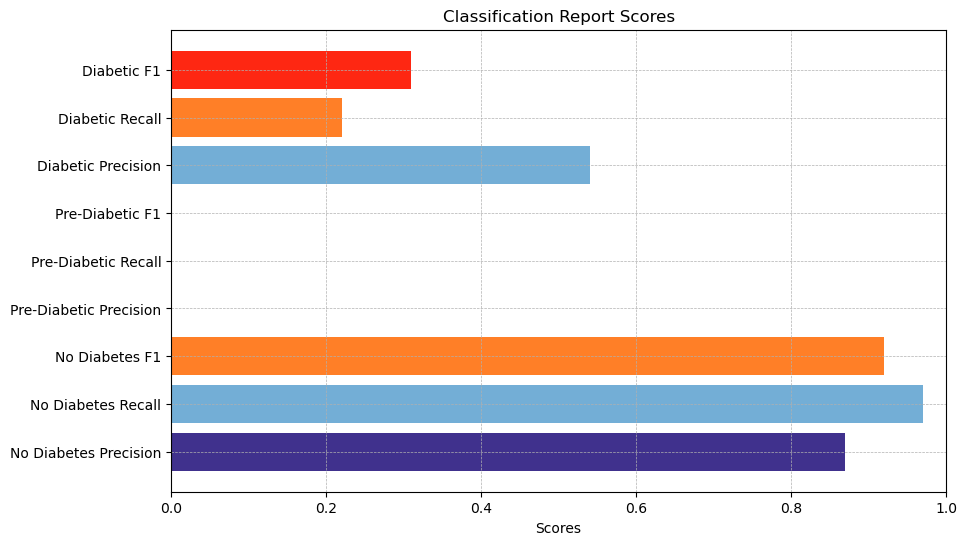

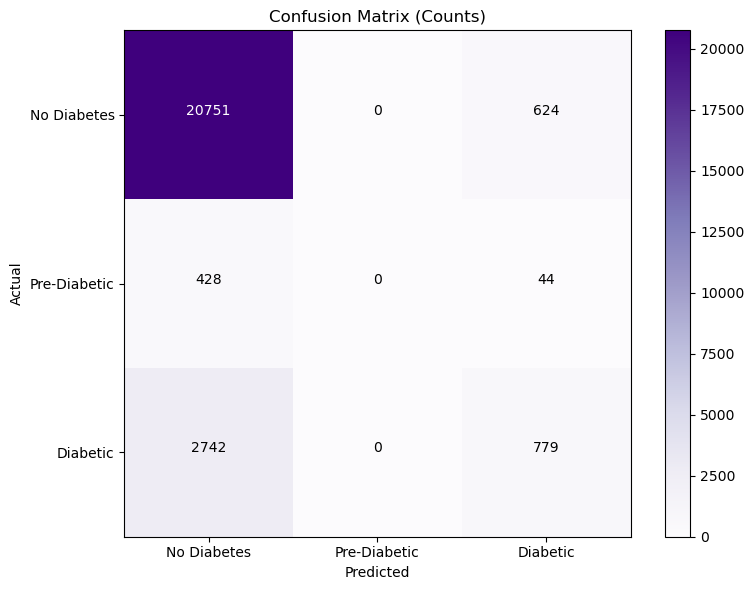

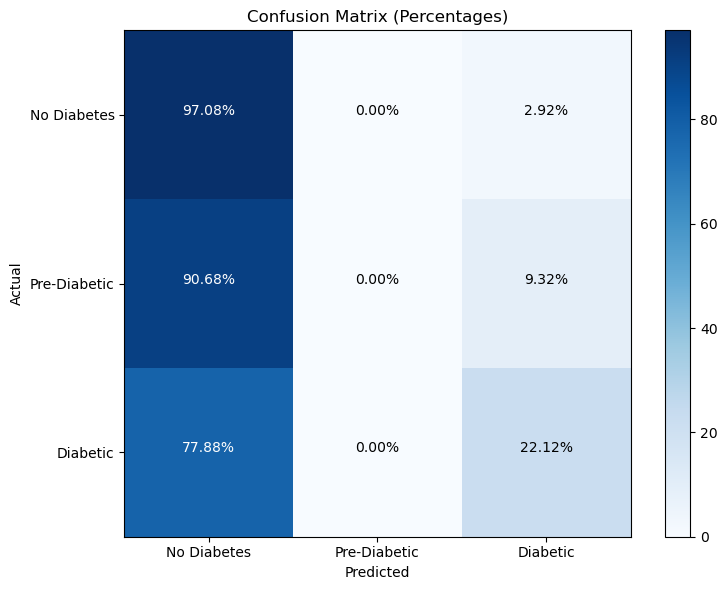

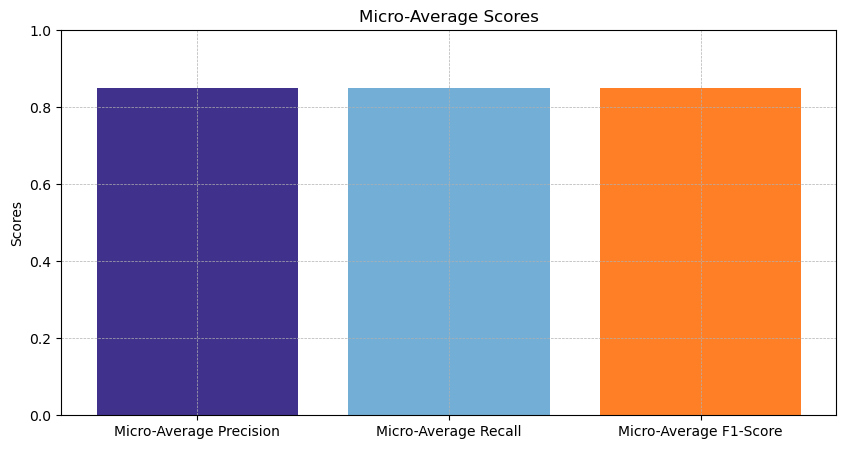

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Hardcoded evaluation results
classification_report_data = """
               precision    recall  f1-score   support
 No Diabetes       0.87      0.97      0.92     21375
Pre-Diabetic       0.00      0.00      0.00       472
    Diabetic       0.54      0.22      0.31      3521
    accuracy                           0.85     25368
   macro avg       0.47      0.40      0.41     25368
weighted avg       0.81      0.85      0.82     25368
"""

confusion_matrix_counts = np.array([
    [20751,     0,   624],
    [  428,     0,    44],
    [ 2742,     0,   779]
])

confusion_matrix_percentages = np.array([
    [97.08070175,  0.        ,  2.91929825],
    [90.6779661 ,  0.        ,  9.3220339 ],
    [77.87560352,  0.        , 22.12439648]
])

micro_avg_scores = {
    "Micro-Average Precision": 0.85,
    "Micro-Average Recall": 0.85,
    "Micro-Average F1-Score": 0.85
}

c64_colors = ["#40318d", "#73aed6", "#ff7f27", "#fe2712", "#a7194b"]

report_data = [0.87, 0.97, 0.92, 0.00, 0.00, 0.00, 0.54, 0.22, 0.31]
categories = ['No Diabetes Precision', 'No Diabetes Recall', 'No Diabetes F1', 
              'Pre-Diabetic Precision', 'Pre-Diabetic Recall', 'Pre-Diabetic F1', 
              'Diabetic Precision', 'Diabetic Recall', 'Diabetic F1']

plt.figure(figsize=(10, 6))
plt.barh(categories, report_data, color=c64_colors[:len(categories)])
plt.xlabel('Scores')
plt.title('Classification Report Scores')
plt.xlim([0, 1])
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_counts, interpolation='nearest', cmap=plt.get_cmap('Purples'))
plt.title('Confusion Matrix (Counts)')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ['No Diabetes', 'Pre-Diabetic', 'Diabetic'])
plt.yticks(tick_marks, ['No Diabetes', 'Pre-Diabetic', 'Diabetic'])

for i in range(3):
    for j in range(3):
        plt.text(j, i, format(confusion_matrix_counts[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_matrix_counts[i, j] > confusion_matrix_counts.max() / 2. else "black")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Plot the confusion matrix (percentages)
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_percentages, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix (Percentages)')
plt.colorbar()
plt.xticks(tick_marks, ['No Diabetes', 'Pre-Diabetic', 'Diabetic'])
plt.yticks(tick_marks, ['No Diabetes', 'Pre-Diabetic', 'Diabetic'])

for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{confusion_matrix_percentages[i, j]:.2f}%",
                 horizontalalignment="center",
                 color="white" if confusion_matrix_percentages[i, j] > confusion_matrix_percentages.max() / 2. else "black")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Plot Micro-Average Scores
plt.figure(figsize=(10, 5))
plt.bar(list(micro_avg_scores.keys()), list(micro_avg_scores.values()), color=c64_colors)
plt.ylabel('Scores')
plt.title('Micro-Average Scores')
plt.ylim([0, 1])
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()
